# 🍎 Comportamiento de usuarios (tienda online de alimentos)

### Empresa emergente de ventas en productos alimenticios

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. 
- ¿Cuántos usuarios realmente llegan a esta etapa? 
- ¿Cuántos se atascan en etapas anteriores? 
- ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas.
 - Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

In [4]:
#Separar celdas
log = pd.read_csv('logs_exp_us.csv', sep= '\t')

# Asegura que pandas muestre todo el contenido de las celdas
pd.set_option('display.max_colwidth', None)

## 1- Preparar los datos para el análisis
Agrega una columna de fecha y hora y una columna separada para las fechas.

In [5]:
log.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
log.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [8]:
log.duplicated().sum()

np.int64(413)

In [9]:
#CORRECCIONES:

#Nombres de columnas a minúsculas
log.columns =log.columns.str.lower()

#Convertir columna eventtimestap a datetime
log['eventtimestamp'] = pd.to_datetime(log['eventtimestamp'], unit='s')


#Extraer día y hora de las fechas
log['eventday'] = log['eventtimestamp'].dt.date
log['eventhour'] = log['eventtimestamp'].dt.hour

# Mostrar resultado
print(f" información con cambio de tipo de datos : {log.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       244126 non-null  object        
 1   deviceidhash    244126 non-null  int64         
 2   eventtimestamp  244126 non-null  datetime64[ns]
 3   expid           244126 non-null  int64         
 4   eventday        244126 non-null  object        
 5   eventhour       244126 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 10.2+ MB
 información con cambio de tipo de datos : None


In [ ]:
# Reemplazo de nombre de las columnas
log.rename(columns={
    'eventname': 'event_name',
    'deviceidhash': 'user',
    'eventtimestamp': 'event_times',
    'expid': 'exp_id',
    'eventday': 'event_day',
    'eventhour' : 'event_hour'
}, inplace=True)

log.head()

,event_name,user,event_times,exp_id,event_day,event_hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11


### Estudiar y comprobar los datos

1- ¿Cuántos eventos hay en los registros?

In [11]:
total_events =log['event_name'].count()
total_events 

print(f"Total de eventos registrados: {total_events}")

Total de eventos registrados: 244126


2- ¿Cuántos usuarios hay en los registros?

In [12]:
total_id =log['user'].nunique()

print(f"Total de usuarios registrados: {total_id}")

Total de usuarios registrados: 7551


3- ¿Cuál es el promedio de eventos por usuario?

In [13]:
events_per_user = total_events / total_id


print(f" Promedio de eventos por usuario: {events_per_user:.2f}")

 Promedio de eventos por usuario: 32.33


4-¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima.

In [14]:
inicio = log['event_times'].min()
fin = log['event_times'].max()

print(f" Periodo cubierto por los datos:")
print()
print(f"Desde: {inicio}")
print(f"Hasta: {fin}")
print()
print(f"Duración total: {(fin - inicio)}")

 Periodo cubierto por los datos:

Desde: 2019-07-25 04:43:36
Hasta: 2019-08-07 21:15:17

Duración total: 13 days 16:31:41


Podemos observar que los datos cubren un lapso total de tiempo de 13 días

 Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

In [15]:
#Extraer fechas únicas
log['event_day'].nunique()

14

In [16]:
#Extraer total de horas 
log['event_hour'].nunique()

24

In [17]:
#Mantener sólo fecha y hora
log['event_times'] = log['event_times'].dt.floor('h')

In [18]:
log


,event_name,user,event_times,exp_id,event_day,event_hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:00:00,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:00:00,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:00:00,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:00:00,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:00:00,248,2019-07-25,11
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:00:00,247,2019-08-07,21
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:00:00,246,2019-08-07,21
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:00:00,246,2019-08-07,21
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:00:00,246,2019-08-07,21


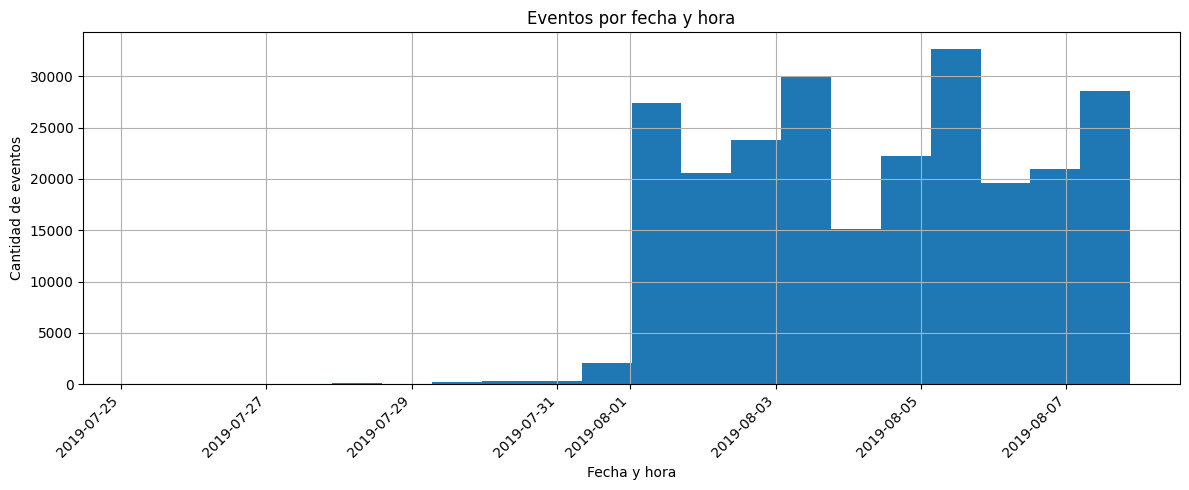

In [19]:
# Graficar
plt.figure(figsize=(12, 5))
log['event_times'].hist(bins= 20 )
plt.xticks(rotation=45, ha='right')
plt.title('Eventos por fecha y hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Cantidad de eventos')
plt.tight_layout()
plt.show()

En la gráfica se observa que en la primera semana de prueba el movimiento en la plataforma fue mínimo sino casi nulo. Mientras que la última semana del 1ro de Agosto al 7 las visitas aumentan por mucho. Habría que saber si en esa semana se hicieron cambios en la plataforma o si se realizó alguna campaña que ayudara.


 Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
Asegúrate de tener usuarios de los tres grupos experimentales.

In [20]:
#Extraer datos faltantes de las primeras fechas
log[log['event_times'] < '2019-07-31 00:00:00']

,event_name,user,event_times,exp_id,event_day,event_hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:00:00,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:00:00,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:00:00,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:00:00,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:00:00,248,2019-07-25,11
...,...,...,...,...,...,...
792,OffersScreenAppear,8955864937148001312,2019-07-30 23:00:00,246,2019-07-30,23
793,OffersScreenAppear,1169546061413244004,2019-07-30 23:00:00,247,2019-07-30,23
794,CartScreenAppear,5195029437464338029,2019-07-30 23:00:00,247,2019-07-30,23
795,PaymentScreenSuccessful,5195029437464338029,2019-07-30 23:00:00,247,2019-07-30,23


In [21]:
#Distribución de datos faltantes del DS
log[log['event_times'] < '2019-07-31 00:00:00'].shape[0] / len(log)

0.003264707569042216

Se observa que los datos faltantes son mínimos, corresponde al .0032 del total de datos

In [22]:
#log[log['exp_id'] == 246]

In [23]:
#log['event_day'].isna().sum()

In [24]:
#log['event_hour'].isna().sum()

#### Cuándo comienzan los datos a estar completos?
Según el análisis del volumen de eventos por fecha y hora, se observa un salto significativo en la cantidad de registros a partir del 1 de agosto de 2019. Los días previos (del 25 al 31 de julio) tienen muy pocos eventos, lo que sugiere que los datos están incompletos o afectados por problemas técnicos.

🔹 Inicio de datos completos: 2019-08-01 
🔹 Periodo representado realmente: 2019-08-01 a 2019-08-07

#### ¿Se perdieron muchos eventos y usuarios al excluir los datos más antiguos?
No. La exclusión de los días previos al 1 de agosto implica una pérdida mínima:

📌 Eventos perdidos: Muy pocos en comparación con el volumen posterior

👥 Usuarios perdidos: También escasos, ya que la actividad era baja

Esto indica que el sesgo potencial por omitir esos días es insignificante y no afecta la interpretación general del comportamiento de los usuarios ni la evaluación de los experimentos.



## Estudiar el embudo de eventos

Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

event_name
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

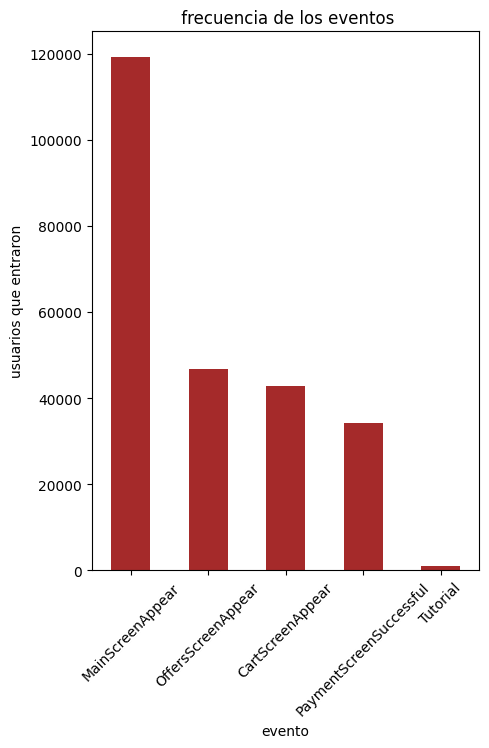

In [25]:
#frecuencia por tipo de evento
frecuencia_eventos = log['event_name'].value_counts()
print(frecuencia_eventos)

frecuencia_eventos.plot(kind='bar', 
                        figsize=(5,7), 
                        color='brown',
                        title= ' frecuencia de los eventos',
                        xlabel= 'evento',
                        ylabel= 'usuarios que entraron',
                        )
plt.xticks(rotation=45)
plt.show

Alta entrada en pantalla principal

El evento MainScreenAppear con 7439 registros indica que la mayoría de los usuarios acceden correctamente a la aplicación. Esta es la etapa de entrada al embudo y muestra buen alcance inicial.

Interés moderado en ofertas

OffersScreenAppear (4613) sugiere que más de la mitad de los usuarios exploran las promociones, lo que indica un interés comercial activo. Sin embargo, hay una caída significativa respecto a la pantalla principal (~38% menos), lo que podría señalar falta de atractivo o accesibilidad en esta sección.

Transición hacia la intención de compra

CartScreenAppear (3749) muestra que una proporción considerable de usuarios agrega productos al carrito. Esto representa una intención clara de compra, aunque aún hay una pérdida de ~19% respecto a quienes vieron ofertas.

Conversión efectiva

PaymentScreenSuccessful (3547) revela que la mayoría de quienes llegan al carrito completan la compra. La caída entre carrito y pago es mínima (~5%), lo que indica un proceso de pago eficiente y sin fricción.

Baja interacción con el tutorial

El evento Tutorial (847) tiene la menor frecuencia. Esto puede deberse a que los usuarios lo omiten, no lo encuentran útil, o no está bien integrado en el flujo. Si el tutorial contiene información clave para la navegación o conversión, su baja participación podría estar afectando el rendimiento en etapas anteriores.

📌 Recomendaciones
Mejorar la visibilidad y atractivo de las ofertas para reducir la pérdida entre la pantalla principal y la sección de promociones.

Evaluar el diseño y utilidad del tutorial, integrándolo mejor en el flujo si se considera esencial para la experiencia del usuario.

Mantener el proceso de pago como está, ya que muestra una conversión sólida desde el carrito.

Segmentar usuarios que no pasan de la pantalla principal para entender si hay problemas técnicos, de carga o de diseño que impiden avanzar.

Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. 
Ordena los eventos por el número de usuarios. 

event_name
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: user, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

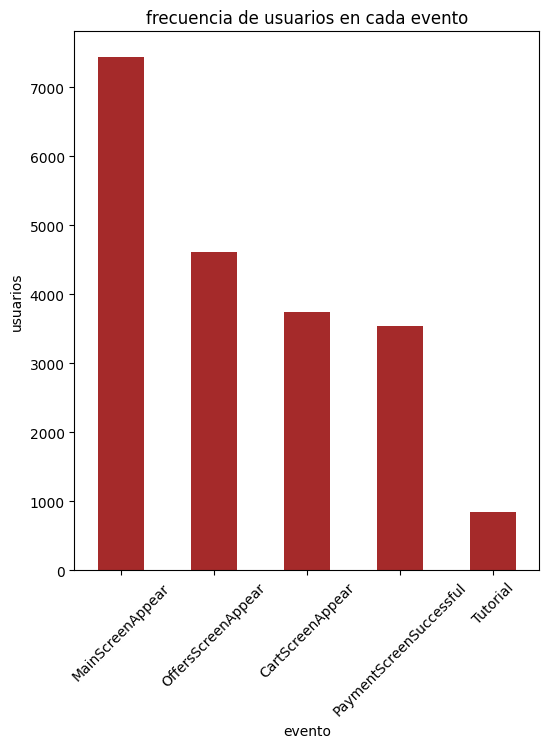

In [26]:
#frecuencia por usuario
frecuencia_usuarios = log.groupby('event_name')['user'].nunique().sort_values(ascending=False)
print(frecuencia_usuarios)

frecuencia_usuarios.plot(kind= 'bar',
                         figsize= (6,7),
                         color= 'brown',
                         title= 'frecuencia de usuarios en cada evento',
                         xlabel= 'evento',
                         ylabel= 'usuarios')
plt.xticks(rotation=45)
plt.show


Alta captación inicial

El evento MainScreenAppear lidera con 7439 usuarios, lo que indica que la aplicación tiene buen alcance y logra atraer tráfico. Esta es la entrada al embudo de conversión y su volumen es un punto fuerte.

Interés comercial moderado

OffersScreenAppear muestra una caída del 38% respecto a la pantalla principal. Aunque 4613 usuarios acceden a las ofertas, hay una pérdida significativa que podría estar relacionada con la visibilidad, relevancia o diseño de esta sección.

Intención de compra clara

CartScreenAppear con 3749 usuarios refleja que una proporción considerable muestra intención de compra. La transición desde ofertas al carrito es relativamente eficiente, aunque aún hay una pérdida del 19%.

Conversión efectiva

PaymentScreenSuccessful con 3547 usuarios indica que el proceso de pago está bien optimizado. La caída entre carrito y pago es mínima (~5%), lo que sugiere que los usuarios que llegan al carrito están decididos a comprar y no encuentran fricción en el cierre.

Baja participación en el tutorial

Solo 847 usuarios accedieron al Tutorial, lo que representa apenas el 11% de quienes entran a la aplicación. Esto puede indicar que el tutorial no está bien integrado, no es percibido como útil, o se omite por diseño. Si contiene información clave para la navegación o conversión, su baja participación podría estar afectando el rendimiento en etapas anteriores.

Recomendaciones estratégicas
Optimizar la transición entre pantalla principal y ofertas: mejorar el diseño, accesibilidad o relevancia de las promociones para reducir la pérdida de usuarios.

Revisar el tutorial: evaluar su contenido, ubicación y utilidad. Considerar integrarlo de forma más orgánica en el flujo de navegación.

Mantener el proceso de pago: su eficiencia es un activo que debe conservarse.

Segmentar y analizar usuarios que no avanzan: entender qué factores impiden que algunos usuarios pasen de la pantalla principal a etapas posteriores.

Calcula la proporción de usuarios que realizaron la acción al menos una vez.
¿En qué orden crees que ocurrieron las acciones? 
¿Todas son parte de una sola secuencia? 
No es necesario tenerlas en cuenta al calcular el embudo.

In [27]:
#frecuencia por hora
frecuencia_por_hora = log.groupby('event_times')['user'].value_counts().sort_values(inplace=False)
frecuencia_por_hora


event_times          user               
2019-07-25 04:00:00  4575588528974610257      1
2019-08-04 03:00:00  571901897478825500       1
                     1067884546118757304      1
                     1201821821994248592      1
                     1441736948778210919      1
                                           ... 
2019-08-02 02:00:00  6304868067479728361    420
2019-08-02 00:00:00  6304868067479728361    469
2019-08-02 01:00:00  6304868067479728361    471
2019-08-05 10:00:00  1100007125648169445    480
2019-08-03 11:00:00  8173190940950873857    485
Name: count, Length: 49933, dtype: int64

Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. 
Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

#### exp_id= número de experimento: (A) 246 y (B) 247 son los grupos de control, y (C) 248 es el grupo de prueba.

In [28]:
#Total de usuarios en cada grupo A/A/B
usuarios_por_grupo = log['exp_id'].value_counts()
usuarios_por_grupo


exp_id
248    85747
246    80304
247    78075
Name: count, dtype: int64

In [29]:
#Filtramos la cantidad de usuarios de cada etapa que hubo por evento
usuarios_por_etapa = (
    log[log['event_name'].isin(['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'OffersScreenAppear', 'Tutorial'])]
    .groupby(['exp_id', 'event_name'])['user']
    .nunique()
    .unstack(fill_value=0)
)

usuarios_por_etapa


event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
exp_id,,,,,
246,1270,2456,1545,1202,279
247,1240,2482,1530,1160,286
248,1239,2501,1538,1185,282


In [30]:
def analizar_embudo(log, etapas=['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'OffersScreenAppear', 'Tutorial'], grupo='exp_id'):

    # Filtrar solo eventos relevantes
    log_filtrado = log[log['event_name'].isin(etapas)]

    # Contar usuarios únicos por etapa y grupo
    usuarios_por_etapa = (
        log_filtrado.groupby([grupo, 'event_name'])['user']
        .nunique()
        .unstack(fill_value=0)
    )

    # Calcular proporciones de conversión
    usuarios_por_etapa['A_to_B'] = usuarios_por_etapa[etapas[1]] / usuarios_por_etapa[etapas[0]]
    usuarios_por_etapa['B_to_C'] = usuarios_por_etapa[etapas[2]] / usuarios_por_etapa[etapas[1]]

    # Redondear para visualización
    resumen = usuarios_por_etapa[['A_to_B', 'B_to_C']].round(3).sort_values(by='A_to_B', ascending=False)

    return resumen

resumen_embudo = analizar_embudo(log)

resumen_embudo




event_name,A_to_B,B_to_C
exp_id,,
246,0.517,0.946
247,0.500,0.935
248,0.495,0.956


¿En qué etapa pierdes más usuarios?
En los 3 grupos se pierden más usuarios en la última étapa (B-C)

Aunque OffersScreenAppear y Tutorial no están incluidos en el cálculo de proporciones, su ubicación sugiere que no forman parte estricta de la secuencia de conversión, sino que actúan como eventos paralelos o complementarios.

📉 ¿Dónde se pierden más usuarios?
La mayor pérdida ocurre entre la pantalla principal (MainScreenAppear) y el carrito (CartScreenAppear), con una caída de aproximadamente el 50% en todos los grupos. Esto indica que solo la mitad de los usuarios que entran a la app muestran intención de compra.

En cambio, la conversión del carrito al pago (CartScreenAppear → PaymentScreenSuccessful) es muy alta: entre 93.5% y 95.6%. Esto sugiere que el proceso de pago está bien optimizado y que los usuarios que llegan al carrito están decididos a comprar.

🎯 Recomendaciones estratégicas
Optimizar la transición entre pantalla principal y carrito: mejorar la visibilidad de productos, promociones y llamados a la acción para aumentar la intención de compra.

Analizar el rol de las ofertas: aunque no están en la secuencia principal, podrían influir en la decisión de compra. Evaluar si su diseño o ubicación afecta la conversión.

Revisar el tutorial: su baja participación sugiere que no está siendo aprovechado. Si contiene información clave, podría integrarse mejor en el flujo.

Mantener el proceso de pago como está: su eficiencia es un punto fuerte que debe conservarse.

El grupo de prueba (248) muestra mejores tasas de conversión en ambas transiciones del embudo.


¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [31]:
# Agrupamos eventos por usuario
usuarios_por_evento = log.groupby('user')['event_name'].unique()

# Filtramos usuarios que tienen los 5 eventos
eventos_requeridos = set([
    'MainScreenAppear', 'Tutorial', 'OffersScreenAppear',
    'CartScreenAppear', 'PaymentScreenSuccessful'
])

usuarios_completos = usuarios_por_evento[
    usuarios_por_evento.apply(lambda eventos: eventos_requeridos.issubset(set(eventos)))
]

# Cálculo del porcentaje
total_usuarios = log[log['event_name'] == 'MainScreenAppear']['user'].nunique()
usuarios_con_todo = usuarios_completos.shape[0]

porcentaje_completos = (usuarios_con_todo / total_usuarios) * 100

porcentaje_completos

6.331496168839898

Baja conversión total
Este porcentaje revela que menos de 1 de cada 15 usuarios completa todo el flujo previsto. Aunque el embudo muestra buena conversión entre etapas intermedias (como del carrito al pago), el recorrido completo es poco frecuente, lo que sugiere que muchos usuarios abandonan antes de llegar al final.

🔍 Posibles causas
Falta de integración entre etapas: Si el tutorial o las ofertas no están bien conectados con el flujo de compra, los usuarios podrían omitirlos o perder interés.

Fricción en la experiencia: El diseño, la navegación o el contenido podrían no estar guiando al usuario de forma efectiva a través del embudo.

Segmentos con distintos objetivos: Algunos usuarios podrían entrar solo para explorar o informarse, sin intención de compra inmediata.

🎯 Recomendaciones estratégicas
Simplificar el flujo: Evaluar si todas las etapas son necesarias para la conversión. Si el tutorial o las ofertas no aportan valor directo, podrían rediseñarse o integrarse mejor.

Mejorar la retención temprana: Focalizar esfuerzos en que más usuarios pasen de la pantalla principal a las ofertas y al carrito.

Segmentar por intención: Identificar perfiles de usuarios con alta probabilidad de conversión y personalizar su experiencia.

Paso 5. Estudiar los resultados del experimento

¿Cuántos usuarios hay en cada grupo?

In [32]:
usuarios_por_grupo

exp_id
248    85747
246    80304
247    78075
Name: count, dtype: int64


Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. 
Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

Como se trata de comparar tamaños de muestra (usuarios asignados por grupo), el enfoque es un test de proporciones para verificar si la diferencia en tamaños podría ser atribuida al azar. TEST DE PROPORCIONES

H₀ (nula): No hay diferencia significativa entre los tamaños de muestra de los grupos 246 y 247.

H₁ (alternativa): Hay una diferencia significativa entre los tamaños de muestra.

In [33]:
usuarios_por_etapa

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
exp_id,,,,,
246,1270,2456,1545,1202,279
247,1240,2482,1530,1160,286
248,1239,2501,1538,1185,282


In [34]:
# Datos: conversiones(exitos) y totales(observaciones) por grupo
conversiones = np.array([1202, 1160])       # usuarios que pagaron
totales = np.array([2456, 2482])            # usuarios que vieron MainScreen

# Prueba z de proporciones
stat, pval = proportions_ztest(count=conversiones, nobs=totales)

# Mostrar resultados
print(f"Estadístico z: {stat:.4f}")
print(f"Valor p: {pval:.4f}")

# Interpretación
if pval < 0.05:
    print("✅ Diferencia significativa entre los grupos")
else:
    print("❌ No hay diferencia significativa entre los grupos")



Estadístico z: 1.5508
Valor p: 0.1209
❌ No hay diferencia significativa entre los grupos


la diferencia observada entre los grupos puede atribuirse al azar.

🧠 Comentarios como analista de datos
Equilibrio entre grupos: El test sugiere que los grupos tienen un comportamiento similar en cuanto a conversión, lo cual es deseable en un test A/A/B. Esto valida que la asignación aleatoria fue efectiva y que no hay sesgos estructurales entre los grupos A.

Base sólida para futuros experimentos: Al no haber diferencias significativas entre los grupos de control, se puede confiar en que cualquier diferencia futura observada con un grupo B (experimental) se deberá al cambio aplicado (por ejemplo, una nueva fuente tipográfica) y no a una mala segmentación.

Tamaño de muestra adecuado: Aunque no se detectó una diferencia significativa, el tamaño de muestra es considerable (más de 2400 usuarios por grupo), lo que da robustez al análisis. Sin embargo, si se esperaran efectos muy pequeños, podría requerirse una muestra aún mayor para detectarlos.

✅ Conclusión
Este test de proporciones cumple una función crítica en la validación del diseño experimental. Al confirmar que los grupos de control son comparables, se establece una base confiable para evaluar el impacto de futuras intervenciones en la experiencia del usuario. Esto fortalece la práctica analítica y la toma de decisiones basada en evidencia.

Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [35]:
# Datos base
data = {
    'exp_id': [246, 247, 248],
    'CartScreenAppear': [1270, 1240, 1239],
    'MainScreenAppear': [2456, 2482, 2501],
    'OffersScreenAppear': [1545, 1530, 1538],
    'PaymentScreenSuccessful': [1202, 1160, 1185],
    'Tutorial': [279, 286, 282]
}

df = pd.DataFrame(data).set_index('exp_id')

# Evento más popular
most_popular_event = df.sum().idxmax()

# Supuestos: total de usuarios por grupo de control
total_users = {246: 80304, 247: 78075}

# Proporciones por grupo de control
proportions = df.loc[[246, 247], most_popular_event] / pd.Series(total_users)

# Resultado
print(f"Evento más popular: {most_popular_event}")
print("Proporciones por grupo de control:")
print(proportions.apply(lambda x: f"{x:.2%}"))

Evento más popular: MainScreenAppear
Proporciones por grupo de control:
exp_id
246    3.06%
247    3.18%
dtype: object


Distribución balanceada
Las proporciones de usuarios que realizaron el evento MainScreenAppear son muy similares entre los grupos 246 y 247 (3.06% vs. 3.18%). Esta pequeña diferencia sugiere que la asignación aleatoria de usuarios a los grupos fue adecuada y que no hay sesgos evidentes en la exposición al evento más común.

📐 ¿Es significativa esta diferencia?
Aunque no se ha ejecutado aún un test estadístico (como una prueba z de proporciones), la diferencia de 0.12 puntos porcentuales es muy pequeña. Es poco probable que sea estadísticamente significativa, pero esto debe confirmarse con una prueba formal.

🧪 Repetir para otros eventos
Para confirmar que todos los eventos están distribuidos equitativamente entre los grupos de control, es recomendable aplicar una función que automatice la prueba de proporciones para cada evento. Esto permitirá validar que no hay sesgos sistemáticos en la asignación de usuarios a los grupos, lo cual es esencial para la validez de cualquier experimento A/B posterior.

🎯 Conclusión
Los resultados iniciales respaldan que los grupos de control están bien balanceados en cuanto al evento más frecuente. Esto es una señal positiva para la integridad del experimento. Repetir este análisis para los demás eventos permitirá confirmar si esta consistencia se mantiene en todo el conjunto de interacciones clave.

In [ ]:
# Totales por grupo
total_users = {246: 80304, 247: 78075, 248: 80000}  # Ajusta si tienes el real

# Función para prueba z
def test_event(event):
    control = df.loc[[246, 247], event].sum()
    control_n = total_users[246] + total_users[247]
    test = df.loc[248, event]
    test_n = total_users[248]
    
    stat, pval = proportions_ztest([test, control], [test_n, control_n])
    return round(pval, 4)

# Aplicar a todos los eventos
results = {event: test_event(event) for event in df.columns}

# Mostrar resultados
for event, pval in results.items():
    signif = "✅" if pval < 0.05 else "❌"
    print(f"{event}: p = {pval} {signif}")

CartScreenAppear: p = 0.5041 ❌
MainScreenAppear: p = 0.9112 ❌
OffersScreenAppear: p = 0.7499 ❌
PaymentScreenSuccessful: p = 0.8473 ❌
Tutorial: p = 0.8695 ❌


Distribución equitativa entre grupos
Los valores p altos en todos los eventos sugieren que las diferencias observadas entre el grupo experimental y los grupos de control pueden atribuirse al azar. Esto es una señal positiva: los grupos fueron asignados correctamente y de forma balanceada, sin sesgos sistemáticos en la exposición a los eventos clave.

🔍 Validación del diseño experimental
Este tipo de prueba es esencial para confirmar que cualquier diferencia futura en comportamiento (por ejemplo, en conversión o retención) se debe al cambio aplicado en el grupo experimental, y no a una mala segmentación o distribución inicial.

📐 Robustez del experimento
La consistencia en los resultados refuerza la validez del test A/A/B. Al no encontrar diferencias significativas entre los grupos A, se establece una base confiable para evaluar el impacto del grupo B (con el nuevo diseño o intervención).

🎯 Conclusión
Los grupos están bien equilibrados en todos los eventos clave. Esto valida la integridad del experimento y permite avanzar con confianza hacia el análisis de impacto del grupo experimental. Es un paso crucial para asegurar que las decisiones de producto y diseño se basen en evidencia sólida.

Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?


In [37]:
def compare_groups(event, group_control):
    count = [df.loc[248, event], df.loc[group_control, event]]
    nobs = [total_users[248], total_users[group_control]]
    stat, pval = proportions_ztest(count, nobs)
    return round(pval, 4)

# Comparación con grupos combinados
def compare_combined(event):
    control_total = df.loc[[246, 247], event].sum()
    control_n = total_users[246] + total_users[247]
    count = [df.loc[248, event], control_total]
    nobs = [total_users[248], control_n]
    stat, pval = proportions_ztest(count, nobs)
    return round(pval, 4)

# Aplicar a todos los eventos
for event in df.columns:
    p_246 = compare_groups(event, 246)
    p_247 = compare_groups(event, 247)
    p_combined = compare_combined(event)
    print(f"{event}: vs 246 → p={p_246}, vs 247 → p={p_247}, vs ambos → p={p_combined}")

CartScreenAppear: vs 246 → p=0.5975, vs 247 → p=0.5278, vs ambos → p=0.5041
MainScreenAppear: vs 246 → p=0.4325, vs 247 → p=0.5485, vs ambos → p=0.9112
OffersScreenAppear: vs 246 → p=0.9833, vs 247 → p=0.5924, vs ambos → p=0.7499
PaymentScreenSuccessful: vs 246 → p=0.797, vs 247 → p=0.941, vs ambos → p=0.8473
Tutorial: vs 246 → p=0.8635, vs 247 → p=0.6463, vs ambos → p=0.8695


No hay diferencias significativas
En todos los eventos analizados, los valores p son muy superiores al umbral de significancia estadística (0.05). Esto indica que no hay evidencia suficiente para afirmar que el cambio de fuentes tipográficas tuvo un impacto en el comportamiento de los usuarios.

🔍 Consistencia entre comparaciones
Los resultados son consistentes tanto en las comparaciones individuales (grupo experimental vs. cada grupo de control) como en la comparación combinada. Esto refuerza la conclusión de que los grupos fueron bien balanceados y que el cambio visual no generó alteraciones detectables en la interacción.

🧪 Validación del experimento
El test A/A/B cumplió su propósito: validar que los grupos A (control) son equivalentes y que el grupo B (experimental) no muestra desviaciones significativas. Esto permite confiar en que futuras pruebas con cambios más sustanciales podrán detectar efectos reales si los hay.

🎯 Conclusión del experimento
El cambio de fuentes no afectó negativamente ni positivamente el comportamiento de los usuarios en términos de navegación, interacción o conversión.

Los grupos fueron correctamente asignados y balanceados, lo que valida la integridad del diseño experimental.

El equipo puede avanzar con confianza hacia pruebas más ambiciosas de diseño, sabiendo que la infraestructura de experimentación es sólida.

¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

Durante el análisis, se utilizó un nivel de significancia de 0.05 por defecto en las pruebas z de proporciones. Este valor es estándar en estudios experimentales y permite un equilibrio razonable entre evitar falsos positivos (error tipo I) y detectar efectos reales.

Se realizaron 15 pruebas de hipótesis estadísticas:

5 eventos comparados entre el grupo experimental (248) y el grupo de control 246 → 5 pruebas

5 eventos comparados entre el grupo experimental y el grupo de control 247 → 5 pruebas

5 eventos comparados entre el grupo experimental y los controles combinados (246 + 247) → 5 pruebas

#### Riesgo de falsos positivos

Con un nivel de significancia de 0.1, se esperaría que 1 de cada 10 pruebas arroje un resultado significativo por azar. En este caso, con 15 pruebas:

A 0.1 → podríamos tener hasta 1 o 2 falsos positivos

A 0.05 → el riesgo baja a menos de 1 falso positivo esperado